# Tarea 1 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, aplicaremos los conocimientos aprendidos en el curso para evaluar el funcionamiento de distintos algoritmos de recomendación sobre el dataset de películas MovieLens. Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

# Setup inicial

## Instalación Visual C++ Build Tools (Windows)

Para poder instalar la librería Surprise que será utilzada en la tarea en un sistema operativo Windows, se necesitan tener instaladas las Visual C++ Build Tools.

Estas pueden ser descargadas a través de [este link](https://visualstudio.microsoft.com/es/visual-cpp-build-tools/). Una vez que hayan descargado el ejecutable, asegúrense de marcar la opción **Desarrollo para el escritorio con C++** y reiniciar su equipo una vez finalice la descarga

## Descarga del dataset

Vamos a descargar el dataset MovieLens-100k proporcionado de manera abierta por [GroupLens de la Universidad de Minnesota](https://grouplens.org/). Este dataset consiste en $100.000$ *ratings* de $943$ usuarios de la plataforma [MovieLens](https://movielens.org/home) en $1.682$ películas.

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=aff2279f7cdc22156853f547c466d53cdd1251c86ba523879a43b03af49085d5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

Saved under ml-100k.zip


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

El archivo *u.data* contiene los $100.000$ ratings. Además, el dataset contiene divisiones de entrenamiento y testeo en los archivos *.base* y *.test*. Los archivos desde u1 hasta u5 corresponden a *splits* del 80% / 20% del dataset original.

Para efectos de esta tarea, solo trabajaremos con los archivos *u1.base* y *u1.test*, por lo que guardaremos su ruta.

In [3]:
train_dir = "ml-100k/u1.base"
test_dir = "ml-100k/u1.test"

# Dataset

Las siguientes celdas les permitirá descargar el dataset MovieLens 100k de manera local.

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos la información contenida en el set de entrenamiento. Para esto, usaremos la librería Pandas, que nos permite manejar bases de datos.

In [4]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


### Pregunta 1 (6 puntos):

Podemos ver que los archivos *u.base* contienen información del usuario, el item, el rating y el timestamp. ¿A qué tipo de información corresponde esto? (Por ejemplo, feedback implícito/explícito, contextual, de contenido, etc).

En base a esto, ¿Qué método de recomendación visto en clase sugiere usar para recomendar películas nuevas a los usuarios?

## Respuesta:


El dataset corresponde a feedback explícito, donde se tiene input explícito de los usuarios relacionado con sus intereses y gustos.

El campo `Usuario` es un elemento explícito y contextual, ya que proporciona información sobre quién es el usuario que está expresando su preferencia.

El campo `Item`, también es un elemento explícito y contextual, ya que relaciona directamente con el contenido que está siendo evaluado.

El campo `Rating` es una señal explícita y cuantitativa de la preferencia del usuario.

El campo `Timestamp` corresponde a una señal contextual pero de feedback implícito, ya que si bien el cliente no marcó explícitamente el feedback, puede tener un contexto implícito, como los cambios en las preferencias a lo largo del tiempo o la relación de las valoraciones con eventos específicos.

Con base en esto, los modelos de Filtrado colaborativo (CF) son utilizado para recomendar  productos basados en la observación de las conexiones históricas entre los usuarios y items disponibles. Podemos utilizar las técnicas de Filtro Colaborativo basado en memoria o basado en modelo. También se puede utilizar un enfoque híbrido entre estos 2 últimos.

Dentro de los modelos de Filtro colaborativo basados en modelo, podemos utilizar algoritmos como redes bayesianas (modelo probabilístico), modelos basados en reglas, como el método de regla de asociación; modelos de clasificación, con técnicas como clustering y redes neuronales. También existen modelos de reducción de Dimensionalidad tales como Modelos de Factores Latentes.

Dado que es muy probablemente la fracción de items evaluados por cada usuario sea pequeña (matriz dispersa), y que el tamaño de la matriz crezca demasiado y tengamos problemas de escalabilidad. Para solventar las dificultades mencionadas, **mi recomendación es utilizar un método de descomposición de matrices (factorización de matrices)**

### Pregunta 2 (6 puntos):

Observemos ahora cómo se distribuyen la cantidad de interacciones por usuario y la cantidad de interacciones por ítem.

[Text(0.5, 1.0, 'Número de interacciones por usuario'),
 Text(0.5, 0, 'Cantidad de items'),
 Text(0, 0.5, 'Cantidad de usuarios')]

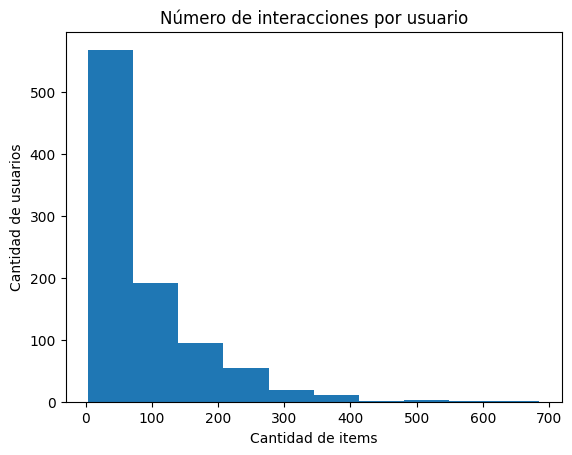

In [5]:
import matplotlib.pyplot as plt

distrib = train_file.groupby(['userid']).count().sort_values(by=['itemid'], ascending=False)
x = distrib['itemid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por usuario', xlabel='Cantidad de items', ylabel='Cantidad de usuarios')

[Text(0.5, 1.0, 'Número de interacciones por item'),
 Text(0.5, 0, 'Cantidad de interacciones'),
 Text(0, 0.5, 'Numero de items')]

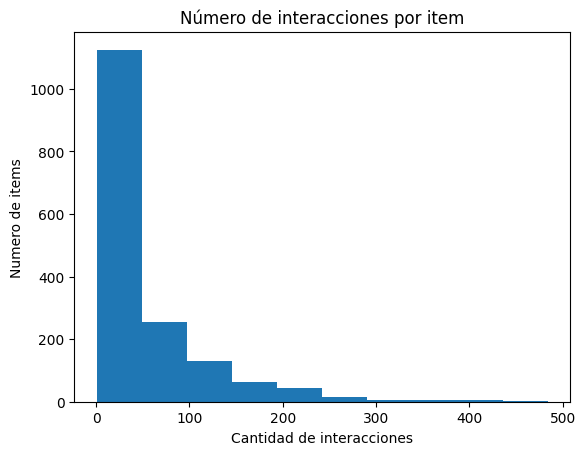

In [6]:
distrib_item = train_file.groupby(['itemid']).count().sort_values(by=['userid'], ascending=False)
x = distrib_item['userid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por item', xlabel='Cantidad de interacciones', ylabel='Numero de items')

Representando la data como histogramas, podemos observar la distribución de las interacciones. Por ejemplo, la primera barra del primer histograma nos indica cuántos usuarios del dataset tienen entre $0$ y $50$ interacciones.

Observe estos datos y comente acerca de la forma de los gráficos y qué significa esta forma en el contexto, tanto para los usuarios como para los ítems. ¿Qué problema podría significar esto para un sistema recomendador?

## Respuesta:

Es posible evidenciar una distribución de cola larga (`long tail`) tanto para los usuarios como para los items al medir la cantidad de interacciones. Long-tail refiere al fenómeno en el que una gran cantidad de elementos (en este caso, películas) tienen muy pocas valoraciones o interacciones, mientras que unas pocas tienen muchas. Los elementos en la "cola larga" tienen tan pocas valoraciones que es difícil encontrar patrones de preferencia confiables para usuarios y realizar recomendaciones precisas.Los elementos populares tienden a recibir más valoraciones y, por lo tanto, pueden ser recomendados con mayor frecuencia, agravando aún más el desequilibrio y limitando la diversidad en las recomendaciones.

Así mismo, nos podemos ver abocados a problemas de `cold-start`. Aquí nos enfrentariamos al problema de nuevos usuarios o nuevos elementos que no tienen suficientes datos históricos para generar recomendaciones precisas.

## Como ver la información de una o más películas

Ahora vamos a aprender algunos métodos de la biblioteca de Pandas que nos permiten ver los detalles de algunas interacciones

In [7]:
# Ver la o las filas específicas del usuario con id = 310
train_file[train_file['userid'] == 310]

,userid,itemid,rating,timestamp
17949,310,50,5,879436177
17950,310,294,1,879436712
17951,310,1142,5,879436467
17952,310,1386,1,879436177


Podemos ver que el usuario con ID $310$ tiene $4$ interacciones en el set de entrenamiento

El archivo *u.item* contiene información adicional de cada película, tal como *título*, *fecha de lanzamiento*, *género*, etc.

La columna *movieid* corresponde a la columna *itemid* de nuestra tabla *train_file*, lo que nos permite conectar la información de esta tabla con nuestro dataset original.

In [8]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [9]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [10]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.


Para ver la información de más de una película, se realizan los siguientes pasos
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

Por ejemplo, veamos cuáles fueron las $4$ películas que vio el usuario $310$

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [50,294,1142,1386]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1142,When We Were Kings (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?When%20We%20W...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1386,Tetsuo II: Body Hammer (1992),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Tetsuo+II%3A+...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Para éste código:
1. `pelis = [50,294,1142,1386]` indica que queremos imprimir los detalles de las películas con estos índices. (En este caso, el índice corresponde al movieid)
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [12]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

movieid
50                   Star Wars (1977)
294                  Liar Liar (1997)
1142        When We Were Kings (1996)
1386    Tetsuo II: Body Hammer (1992)
Name: title, dtype: object

## Preparar entorno
Para generar los modelos recomendadores, utilizaremos la librería [***Surprise***](https://github.com/NicolasHug/Surprise) desarrollada por Nicolas Hug.

In [13]:
!pip install scikit-surprise==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811599 sha256=a99441b71390a6fbc298913023bbc74debd088961ebead386fb9b3401067968f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en esta tarea

In [14]:
import surprise
print(surprise.__version__)
from surprise.model_selection import PredefinedKFold

import numpy as np
from collections import defaultdict

1.1.3


## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [41]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [42]:
# Declarar el objeto recomendador UserKnn
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [43]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [44]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.4420114287810444, details={'actual_k': 6, 'was_impossible': False})

El valor de `est` es la estimación que el modelo hace para el usuario y objeto correspondiente. En este caso, el modelo predice que el usuario $457$ le daría una calificación de $2.44$ al item $37$.

El valor de `r_ui` es el valor real que el usuario le dio al objeto. Si en el set de entrenamiento, existiera un registro de la calificación que le dio el usuario $457$ al item $37$, esta se vería reflejada en ese valor, el cual no necesariamente será el mismo que el valor predicho por el agente. En eeste caso, como el usuario $457$ no ha visto el item $37$, este valor es `None`

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [45]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [46]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [47]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]


Cada item de la lista `top_n` representa una tupla de el ID del ítem recomendado y su calificación predicha.

Usemos ahora la función `.loc` para analizar las películas recomendadas.

In [48]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1347,"Ballad of Narayama, The (Narayama Bushiko) (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Narayama%20Bu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

La biblioteca Surprise tiene un modulo `accuracy` que permite calcular distintas métricas de error, entre ellas el RMSE y el MAE.

Para evaluar un modelo entrenado, utilizamos la función `.test()` sobre el testset, lo que nos permite calcular la diferencia entre los valores predichos y los valores reales para los elementos del set de testeo.

In [49]:
from surprise import accuracy

k_values = [5, 10, 15] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0347
MAE:  0.8197
RMSE: [1.0880066691561228, 1.0470099288376837, 1.034653750064812]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8197339697540738]


### Evaluar en base a error de prediccion (RMSE y MAE)

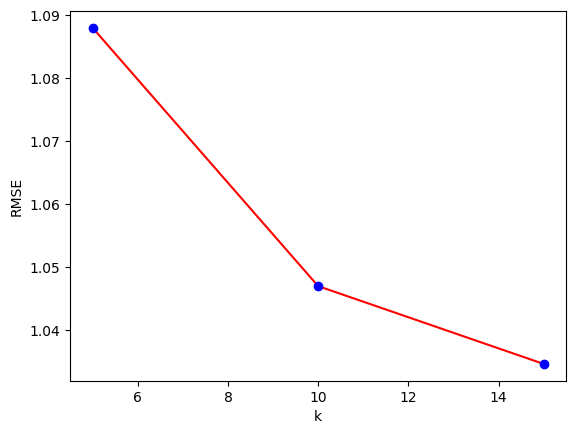

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

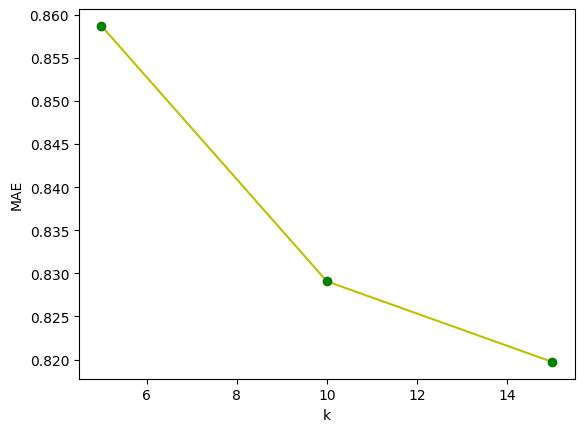

In [51]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

Entrenamos un nuevo agente con valores de `k = 5, 10, 15` y podemos observar que tanto el valor del RMSE y del MAE disminuyeron con un mayor valor de `k`.

### Pregunta 3 (12 puntos):

Continúe el estudio de los hiperparámetros para los valores de `k = 5, 10, 30, 50, 70, 100 y 150`. Grafique sus resultados y conteste:

* Explique, en sus propias palabras, qué se mide con las métricas de RMSE y MAE.
* Qué valor de `k` entrega los mejores resultados.
* Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma.

#### Respuesta:

In [52]:
k_values = [5, 10, 30, 50, 70, 100, 150] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  # Complete el código.
  break # Eliminar

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0248
MAE:  0.8139
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0227
MAE:  0.8136
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0249
MAE:  0.8164
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0278
MAE:  0.8200


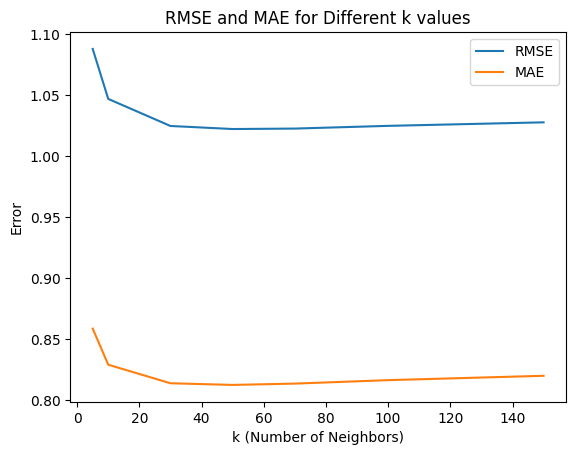

In [53]:
from surprise import KNNBasic, accuracy

k_values = [5, 10, 30, 50, 70, 100, 150]  # definir distintos valores de vecinos (k)
mae_values = []  # para almacenar resultados de MAE
rmse_values = []  # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))


plt.plot(k_values, rmse_values, label='RMSE')
plt.plot(k_values, mae_values, label='MAE')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error')
plt.title('RMSE and MAE for Different k values')
plt.legend()
plt.show()

In [54]:
#Almacenemos el RMSE y MAE para el k = 50 EN U-kNN

myUserKnn50 = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True})
myUserKnn50.fit(trainset)
predictions_UKNN = myUserKnn50.test(testset)
RMSE_UKNN= accuracy.rmse(predictions_UKNN)
MAE_UKNN = accuracy.mae(predictions_UKNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8125


**RMSE (Root Mean Squared Error)**:
El RMSE es una medida que calcula la raíz cuadrada del promedio de los errores cuadrados entre las predicciones del modelo y los valores reales.

**MAE (Mean Absolute Error):**
El MAE es una medida que calcula el promedio de los valores absolutos de los errores entre las predicciones del modelo y los valores reales. En lugar de elevar al cuadrado los errores como en el RMSE, el MAE considera los valores absolutos directamente.

Para este ejercicio, es posible evidenciar que el $k$ que genera mejores resultados (menor RMSE y MAE) es 50. Con valores de $K$ superiores empezamos a ver como la curva de error tiende a aumentar. Esto se relaciona con el trade-off entre sesgo y varianza.

La forma de la gráfica de error es la típica que se observa en los modelos de KNN, debido al tradeoff entre sesgo y varianza. Cuando $k$ es pequeño (por ejemplo, 5), el modelo considera solo unos pocos vecinos cercanos para hacer predicciones. Esto puede llevar a un alto nivel de varianza, ya que las pequeñas diferencias en los datos de entrenamiento pueden resultar en predicciones muy diferentes.

A medida que $k$ aumenta (por ejemplo, 150), el modelo considera un número mucho mayor de vecinos cercanos para hacer predicciones. Esto puede llevar a un mayor sesgo, ya que el modelo podría perder algunos patrones más específicos presentes en el conjunto de datos. Sin embargo, a medida que el modelo se vuelve más estable y menos sensible a pequeñas variaciones en los datos de entrenamiento, es probable que la varianza disminuya.

Encontramos un óptimo global porque al Buscar un valor óptimo de $k$, implica encontrar un equilibrio entre un modelo que se ajuste lo suficiente a los datos (bajo sesgo) sin ser demasiado sensible a las fluctuaciones (baja varianza). El objetivo es seleccionar un $k$ que minimice el error total en el conjunto de test, logrando así un buen balance entre sesgo y varianza.

### Pregunta 4 (12 puntos):

Repita el experimento anterior, pero utilizando los algoritmos de IKNN y [FunkSVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) de la biblioteca Surprise. Recuerde evaluar el rendimiento de sus modelos para las métricas de RMSE y MAE

* Para el caso de IKnn vuelva a realizar un análisis con los valores de `k = 5, 10, 30, 50, 70, 100` e identifique el valor que entrega el mejor resultado.

#### Respuesta:

###IKNN

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2026
MAE:  0.9458
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1183
MAE:  0.8810
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0535
MAE:  0.8310
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0474
MAE:  0.8257
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0489
MAE:  0.8294
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0528
MAE:  0.8364
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0585
MAE:  0.8448


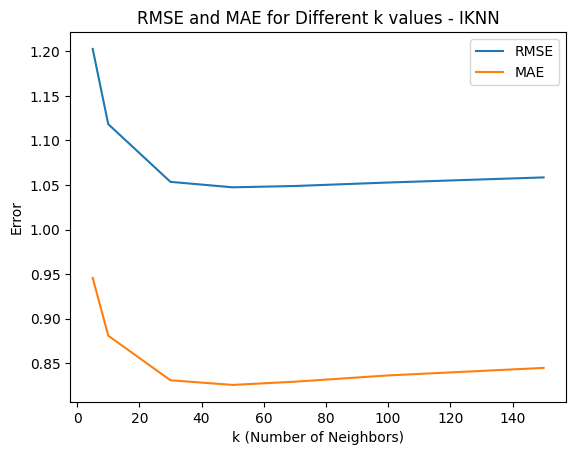

In [55]:
k_values = [5, 10, 30, 50, 70, 100, 150]  # definir distintos valores de vecinos (k)
mae_values = []  # para almacenar resultados de MAE
rmse_values = []  # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False}) #Aqui se declara que no queremos UKNN sino IKNN
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))


plt.plot(k_values, rmse_values, label='RMSE')
plt.plot(k_values, mae_values, label='MAE')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error')
plt.title('RMSE and MAE for Different k values - IKNN')
plt.legend()
plt.show()

In [56]:
#Almacenemos el RMSE y MAE para el k = 50 EN I-kNN

myIKnn50 = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
myIKnn50.fit(trainset)
predictions_iKNN = myIKnn50.test(testset)
RMSE_iKNN= accuracy.rmse(predictions_iKNN)
MAE_iKNN = accuracy.mae(predictions_iKNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0474
MAE:  0.8257


El comportamiento de la gráfica de error es muy similar a la del algoritmo UKnn como era de esperarse. Aunque aqui vemos unos valores de error levemente superiores a los obtenidos con U-kNN. El $k$ óptimo en este caso también es 50. Ese es el valor de $K$ que minimiza el sesgo y la varianza del modelo.

### FunkSVD

In [57]:
from surprise import SVD

algo = SVD()
algo.fit(trainset)
predictions_SVD = algo.test(testset)
RMSE_SVD = accuracy.rmse(predictions_SVD)
MAE_SVD = accuracy.mae(predictions_SVD)

RMSE: 0.9519
MAE:  0.7484


Es interesante encontrar que el algortimo de FunkSVD genera un menor error tanto en RMSE (0.95) y MAE (0.75) vs los métodos de U-KNN y I-KNN.

### Pregunta 5 (12 puntos):

Genere una tabla que compare los resultados de los métodos de UKnn, IKnn y FunkSVD tanto para RMSE como para MAE. En el caso de IKnn y UKnn, solo utilice el modelo con el valor de `k` que haya entregado los mejores resultados. Identifique qué método logró el mejor resultado para ambas métricas.

Comente acerca de estos resultados. Explique por qué cree que se obtuvieron estos resultados utilizando la materia aprendida en el curso respecto al funcionamiento de cada método.

#### Respuesta:

In [58]:
results = {
    'Método': [ 'Item-Based k-NN', 'User-Based k-NN','FunkSVD'],
    'RMSE': [RMSE_iKNN, RMSE_UKNN, RMSE_SVD],
    'MAE': [MAE_iKNN, MAE_UKNN, MAE_SVD]
}

results_df = pd.DataFrame(results)
results_df

,Método,RMSE,MAE
0,Item-Based k-NN,1.047411,0.825738
1,User-Based k-NN,1.022326,0.812505
2,FunkSVD,0.951916,0.748382



Estos resultados, donde FunkSVD supera a User-Based k-Nearest Neighbors (UKnn) y este último supera a Item-Based k-Nearest Neighbors (IKnn), se pueden atribuir a que FunkSVD es una técnica poderosa para capturar relaciones complejas y patrones en los datos.  Es posible que el conjunto de datos tenga patrones intrincados que puedan ser mejor capturados por una técnica de factorización matricial como FunkSVD.

El enfoque U-KNN se basa en la similitud entre usuarios. Sin embargo, este enfoque puede ser más susceptible al ruido y a la variabilidad en las preferencias de los usuarios, especialmente cuando se tiene un conjunto de datos disperso o con valores faltantes. IKnn se basa en la similitud entre elementos y, en general, puede ser menos preciso que UKnn o FunkSVD en ciertos casos. Esto se debe a que las relaciones entre elementos pueden ser menos distintivas o relevantes que las relaciones entre usuarios. Además, el enfoque de elementos puede sufrir más de la maldición de la dimensionalidad en comparación con UKnn, ya que la similitud entre elementos puede ser menos estable.

### Pregunta 6 (12 puntos):

Escoja un usuario del set de datos e imprima los títulos de las películas que ha visto (según el set de entrenamiento) y su calificación. Luego, imprima una lista de 5 recomendaciones entregadas para este usuario por cada uno de los $3$ modelos entrenados y compare estas listas. Comparando los gustos en la historia del usuario y las recomendaciones entregadas por los modelos, le hacen sentido estas recomendaciones. (Su respuesta no necesariamente debe coincidir con las conclusiones finales de la sección experimental).

Evite usar a los usuarios 457 y 310 que ya fueron estudiados en la tarea. Recuerde imprimir al menos los títulos de cada película, tanto en la historia del usuario como en las recomendaciones para poder identificarlas correctamente.

#### Respuesta:

A continuación, se ilustra las peliculas que ha visto el userid = 69.

In [59]:
specific_user_id = [69] # Seleccionamos el user_id

filtered_row = train_file[train_file['userid'].isin(specific_user_id)]
merged_data = filtered_row.merge(info_file, left_on='itemid', right_on='movieid', how='inner') #Joineamos con la tabla info para traer el título de la película
pelis_user_69 = merged_data[['userid', 'itemid', 'rating', 'title']] #Traemos solo los campos que necesitamos
pelis_user_69

,userid,itemid,rating,title
0,69,7,5,Twelve Monkeys (1995)
1,69,42,5,Clerks (1994)
2,69,50,5,Star Wars (1977)
3,69,79,4,"Fugitive, The (1993)"
4,69,98,5,"Silence of the Lambs, The (1991)"
5,69,117,4,"Rock, The (1996)"
6,69,123,4,"Frighteners, The (1996)"
7,69,124,4,Lone Star (1996)
8,69,172,5,"Empire Strikes Back, The (1980)"
9,69,181,5,Return of the Jedi (1983)


Ahora, extraigamos el top 5 de recomendaciones de los 3 métodos:

In [60]:
# Obtener el top 5 de predicciones del método UkNN
top_n_uknn = get_top_n(predictions_UKNN, n=5)
top_n_uknn = top_n_uknn["69"]
top_n_uknn

[('427', 4.440136273930584),
 ('12', 4.3608700851210935),
 ('174', 4.32016465009241),
 ('100', 4.2599982412792885),
 ('56', 4.219813542568512)]

In [61]:
# Obtener el top 5 de predicciones del método ikNN
top_n_iknn = get_top_n(predictions_iKNN, n=5)
top_n_iknn = top_n_iknn["69"]
top_n_iknn

[('1134', 3.760175868433275),
 ('9', 3.7515891349331167),
 ('1143', 3.751408733366772),
 ('268', 3.7506613637252433),
 ('175', 3.7495695792192882)]

In [62]:
# Obtener el top 5 de predicciones del método FunkSVD
top_n_svd = get_top_n(predictions_SVD, n=5)
top_n_svd = top_n_svd["69"]
top_n_svd

[('427', 4.556742171121649),
 ('100', 4.502271057587782),
 ('56', 4.3944771201654405),
 ('12', 4.309766528947953),
 ('174', 4.213904328138014)]

Ahora, pongamoslo más ordenado en una tabla:

In [63]:
# Crear DataFrames a partir de las listas de tuplas
funkSVD_df = pd.DataFrame(top_n_svd, columns=['itemid', 'prediccion'])
userKNN_df = pd.DataFrame(top_n_uknn, columns=['itemid', 'prediccion'])
itemKNN_df = pd.DataFrame(top_n_iknn, columns=['itemid', 'prediccion'])

# Agregar la columna de método
funkSVD_df['metodo'] = 'FunkSVD'
userKNN_df['metodo'] = 'User-Based k-NN'
itemKNN_df['metodo'] = 'Item-Based k-NN'

# Concatenar los DataFrames
combined_df = pd.concat([funkSVD_df, userKNN_df, itemKNN_df], ignore_index=True)

combined_df['itemid'] = combined_df['itemid'].astype('int64')
merged = combined_df.merge(info_file, left_on='itemid', right_on='movieid', how='left')
result = merged[['itemid', 'title', 'prediccion', 'metodo']]
result

,itemid,title,prediccion,metodo
0,427,To Kill a Mockingbird (1962),4.556742,FunkSVD
1,100,Fargo (1996),4.502271,FunkSVD
2,56,Pulp Fiction (1994),4.394477,FunkSVD
3,12,"Usual Suspects, The (1995)",4.309767,FunkSVD
4,174,Raiders of the Lost Ark (1981),4.213904,FunkSVD
5,427,To Kill a Mockingbird (1962),4.440136,User-Based k-NN
6,12,"Usual Suspects, The (1995)",4.360870,User-Based k-NN
7,174,Raiders of the Lost Ark (1981),4.320165,User-Based k-NN
8,100,Fargo (1996),4.259998,User-Based k-NN
9,56,Pulp Fiction (1994),4.219814,User-Based k-NN


Es interesante observar que los métodos FunkSVD y uKNN coinciden en la recomendación de las 5 peliculas en su top(5): movieid = 12 , 174, 100 y 56 y 427 que corresponden a los títulos:

*   Usual Suspects, The (1995)
*   Raiders of the Lost Ark (1981)
*   Fargo (1996)
*   Pulp Fiction (1994)
*   To Kill a Mockingbird (1962)

Existen diferencias en el rating predicho entre los 2 métodos. Mientras que FunkSVD estima valores entre 4.21 y 4.56, uKNN predice un rango de calificaciones más corto entre 4.22 y 4.44.

A diferencia de estos 2 métodos, el método iKNN no encuentra coincidencia con las otras 2 técnicas y la predicción de calificación está sobre los 3.75 y 3.76. Aquí se nota la diferencia de precisión que teniamos al evaluar los RMSE y MAE en el punto anterior.